# modelo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split

import PIL
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Dataset and Dataloader


In [ ]:
PATH = '/content/drive/MyDrive/Training_SM/Training_Unet'
TRAIN_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Imagenes'
TRAIN_MASKS_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Mask'
#TEST_PATH ='/content/drive/MyDrive/WHO/IARCImageBankColpo/Case 023/AAIR1.jpg'
#TEST_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Type_1_test'
TEST_PATH = '/content/drive/MyDrive/Training_SM/Training_Unet/Test_CITOBOT'

In [ ]:
IMG_MASK = os.listdir(TRAIN_MASKS_PATH)
IMG_IMG = os.listdir(TRAIN_PATH)
print(len(IMG_MASK))
print(len(IMG_IMG))

1050
1050


Dataset

In [ ]:
class Colposcopia_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)

            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img

        return img, mask

Tranformaciones


In [ ]:
transform_data = T.Compose([
                 T.Resize([224,224]),
                 T.ToTensor()])

In [ ]:
transform_data_gray = T.Compose([
                 T.Resize([224,224]),
                 T.Grayscale(num_output_channels=1),
                 T.ToTensor()])

Dataloaders

In [ ]:
full_dataset = Colposcopia_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data_gray)


In [ ]:
BATCH_SIZE = 3
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset)-TRAIN_SIZE

print(TRAIN_SIZE,VAL_SIZE)

train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

840 210
840 210


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])


In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==3: break

0 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
1 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
2 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])
3 torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])


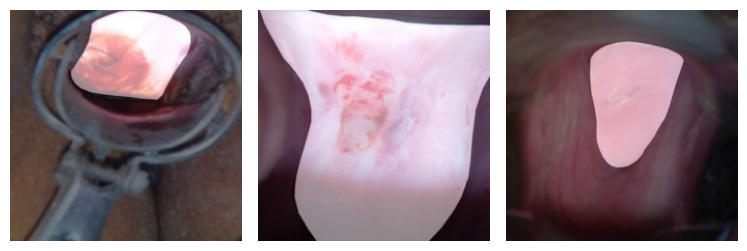

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_bacth(imgs,masks):
    plt.figure(figsize=(20,10))
    for i in range (BATCH_SIZE):
      plt.subplot(4, 8, i+1)
      img = imgs[i,...].permute(1,2,0).numpy()
      mask = masks[i,...].permute(1,2,0).numpy()
      plt.imshow(img)
      plt.imshow(mask,'gray',alpha = 0.5)  #alpha controlla opacidad
      plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_mini_bacth(imgs,masks)


Unet model

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)


In [ ]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),

                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)

    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)

In [ ]:
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28

        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14

        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)

In [ ]:
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

In [ ]:
#preds = test()

In [ ]:
#print(preds.shape) #el tamaño de salida debe ser igual al de la entrada

Accuracy

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
len(train_loader)

280

Learning rate

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
    return log_lrs, losses, accuracies

Entrenamiento

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')

# Train model

In [ ]:
torch.manual_seed(2)
model = UNET(3, 10, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.0001, momentum=0.95,
                                 weight_decay=0.001)


In [ ]:
lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-5, end_val=10)

cost:0.7762, lr: 0.0000, acc: 0.2296
cost:0.7151, lr: 0.0000, acc: 0.3052
cost:0.7788, lr: 0.0000, acc: 0.2329
cost:0.7486, lr: 0.0000, acc: 0.2841
cost:0.7499, lr: 0.0000, acc: 0.2868
cost:0.6937, lr: 0.0000, acc: 0.2636
cost:0.7388, lr: 0.0000, acc: 0.2824
cost:0.7714, lr: 0.0000, acc: 0.2494
cost:0.6860, lr: 0.0000, acc: 0.3120
cost:0.7690, lr: 0.0000, acc: 0.2413
cost:0.7391, lr: 0.0000, acc: 0.2408
cost:0.7812, lr: 0.0000, acc: 0.2470
cost:0.7277, lr: 0.0000, acc: 0.2661
cost:0.7776, lr: 0.0000, acc: 0.2493
cost:0.7276, lr: 0.0000, acc: 0.2885
cost:0.7572, lr: 0.0000, acc: 0.2536
cost:0.7639, lr: 0.0000, acc: 0.2712
cost:0.7111, lr: 0.0000, acc: 0.3018
cost:0.7490, lr: 0.0000, acc: 0.2674
cost:0.7455, lr: 0.0000, acc: 0.2581
cost:0.7587, lr: 0.0000, acc: 0.2833
cost:0.6713, lr: 0.0000, acc: 0.3026
cost:0.7396, lr: 0.0000, acc: 0.2604
cost:0.7255, lr: 0.0000, acc: 0.2876
cost:0.7637, lr: 0.0000, acc: 0.2626
cost:0.7503, lr: 0.0000, acc: 0.2513
cost:0.7690, lr: 0.0000, acc: 0.2695
c

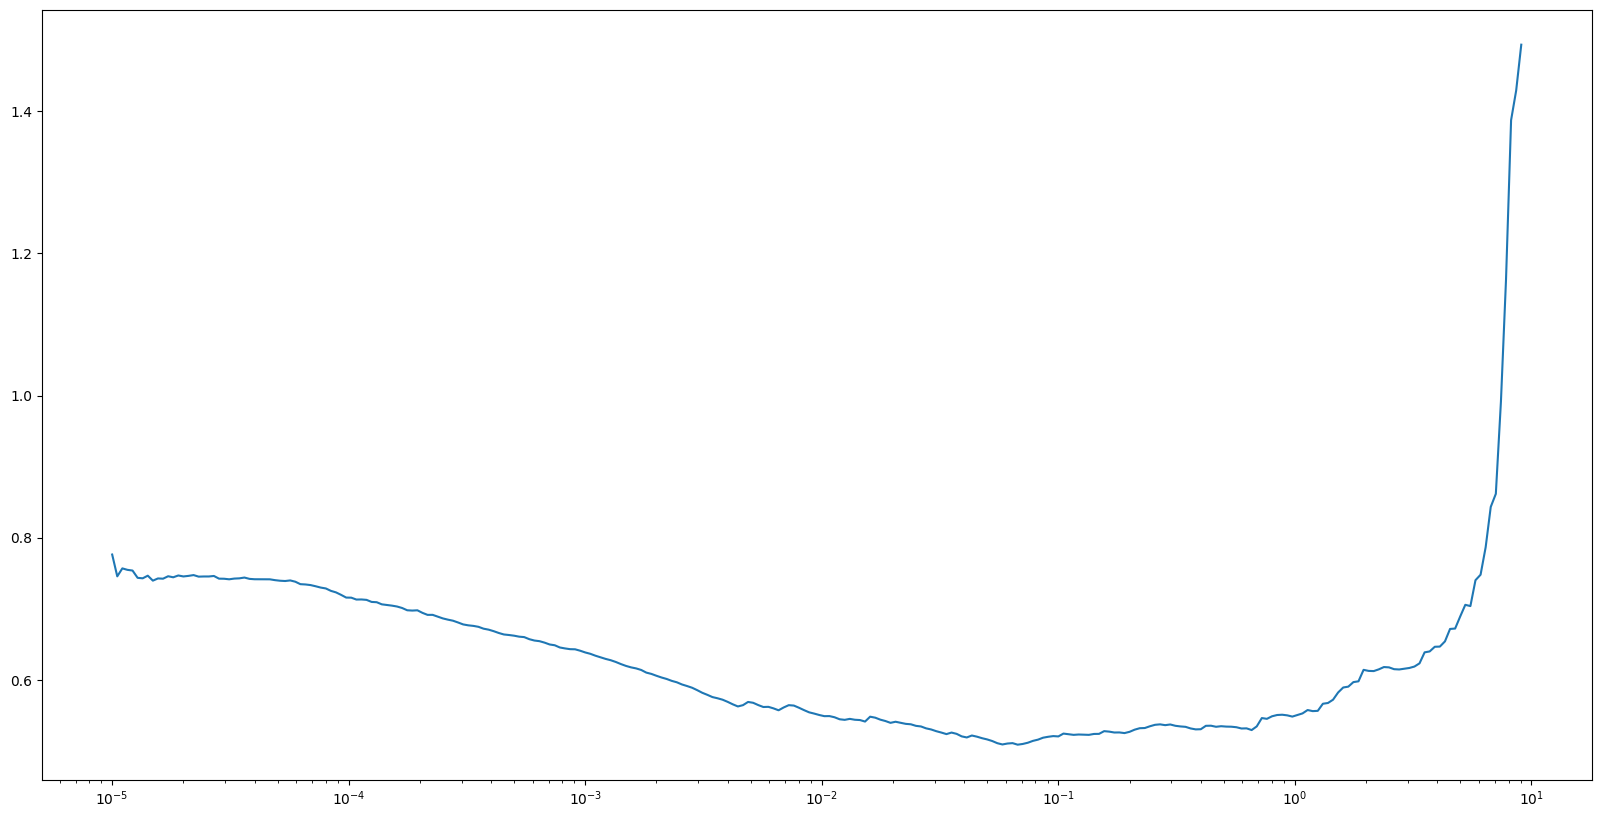

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [ ]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 10
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 25, train cost: 0.5893, val cost: 0.4762,train acc: 0.6859, val acc: 0.7799,dice: 0.5053259134292603, iou: 0.33808431029319763
epoch: 0, mb: 50, train cost: 0.5427, val cost: 0.4598,train acc: 0.7413, val acc: 0.7972,dice: 0.6025348901748657, iou: 0.4311627447605133
epoch: 0, mb: 75, train cost: 0.5189, val cost: 0.4681,train acc: 0.7598, val acc: 0.7956,dice: 0.6073486804962158, iou: 0.43610966205596924
epoch: 0, mb: 100, train cost: 0.4914, val cost: 0.3965,train acc: 0.7794, val acc: 0.8271,dice: 0.6933534145355225, iou: 0.5306357741355896
epoch: 0, mb: 125, train cost: 0.4756, val cost: 0.4221,train acc: 0.7895, val acc: 0.8138,dice: 0.6591472625732422, iou: 0.4915880858898163
epoch: 0, mb: 150, train cost: 0.4680, val cost: 0.4149,train acc: 0.7912, val acc: 0.8067,dice: 0.6814736127853394, iou: 0.5168448686599731
epoch: 0, mb: 175, train cost: 0.4583, val cost: 0.3970,train acc: 0.7959, val acc: 0.8287,dice: 0.6753549575805664, iou: 0.5098384022712708
epoch: 0, mb: 

plot algunas imagenes

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_bacth(imgs_val, preds.unsqueeze(1))

torch.Size([3, 224, 224])


NameError: ignored

In [ ]:
test_set = Colposcopia_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
#plot_mini_bacth(imgs_test, preds.unsqueeze(1))

torch.Size([3, 224, 224])


NameError: ignored

# Guardar modelo entrenado 1



In [ ]:
model_path = '/content/drive/MyDrive/PROYECTO_GRADO/modelUnetT.pth'

In [ ]:
torch.save(
    model.state_dict(),
    model_path)

In [ ]:
model.state_dict()['first_conv.double_conv.0.conv1.weight'].shape

torch.Size([4, 3, 3, 3])

In [ ]:
model

UNET(
  (first_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_Conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
            (conv1): Conv2

cargar modelo

# Guardar modelo entrenado 2

In [ ]:
scripted_model = torch.jit.script(model.cpu())
scripted_model.save('model.zip')


cargar